[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ktehranchi/energy310_notebooks/blob/main/notebooks/02_economic_dispatch_with_PyPSA_USA.ipynb)


In [ ]:
# Install required packages if running in Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("Installing required packages for Google Colab...")
    %pip install -q pypsa matplotlib numpy pandas seaborn scipy networkx gurobipy
    print("Downloading helpers.py...")
    !wget -q https://raw.githubusercontent.com/ktehranchi/energy310_notebooks/main/notebooks/helpers.py
    print("Setup complete!")
else:
    print("Not running in Colab. Skipping package installation.")


# Economic Dispatch with PyPSA-USA

In [2]:
# Import necessary libraries
import pypsa
import matplotlib.pyplot as plt
import logging

from helpers import (
    plot_generator_marginal_costs,
    plot_energy_balance,
    plot_capacity_comparison
)

logger = logging.getLogger("gurobipy")
logger.propagate = False

pypsa.__version__

'0.35.2'

### Single Time-step Economic Dispatch Example

$$
\min_{p} \sum o_{g} p_{g}
$$

$$
\text{st:          } \quad \quad 
$$

$$
p_{g} \le \widetilde{p}^{\max}_{g}\,\overline{P}_{g}
$$

$$
\sum_{g \in G} p_{g} = D
$$


PyPSA's optimization function `pypsa.network.optimize()` builds the optimization model, either a simulation or production cost model depending on the extendable settings of each component.

We need to ensure all components are set to non-extendable before solving the network.

In [ ]:
network = pypsa.Network('../data/examples/elec_s380_c7a_ec_lv1.5_RPS-REM-TCT-1h_E.nc')

INFO:pypsa.network.io:New version 1.0.3 available! (Current: 0.35.2)
INFO:pypsa.network.io:Imported network '' has buses, carriers, generators, global_constraints, links, loads, storage_units


In [4]:
# You can use this to create an interactive list of components
network.components.keys()

dict_keys(['sub_networks', 'buses', 'carriers', 'global_constraints', 'lines', 'line_types', 'transformers', 'transformer_types', 'links', 'loads', 'generators', 'storage_units', 'stores', 'shunt_impedances', 'shapes'])

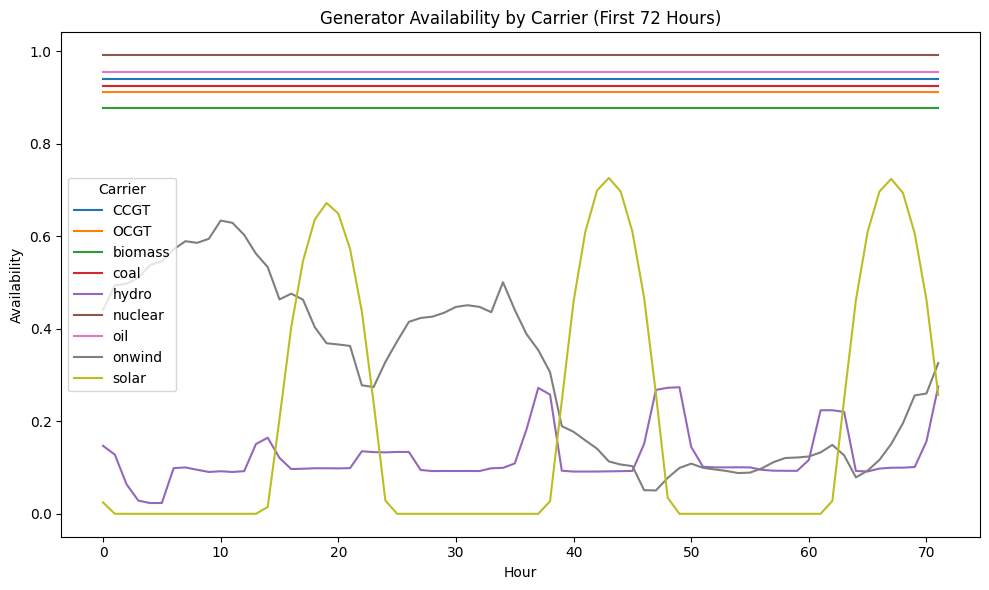

In [11]:
# Prepare the data
# Ensure the index used for the x-axis is something matplotlib will accept (e.g. range or integer)
df = (
    network.generators_t.p_max_pu
    .iloc[:72]  # first 72 hours, automatic with integer location
    .T
    .groupby(network.generators.carrier)
    .mean()
    .T
)

# Use integer x-axis for matplotlib, as df.index may be tuples (which cause issues)
x = range(len(df))

fig, ax = plt.subplots(figsize=(10, 6))
for carrier in df.columns:
    ax.plot(x, df[carrier].values, label=str(carrier))

ax.set_xlabel('Hour')
ax.set_ylabel('Availability')
ax.set_title('Generator Availability by Carrier (First 72 Hours)')
ax.legend(title='Carrier')
plt.tight_layout()
plt.show()

In [12]:
# Track and set all extendable attributes to False for all components in the network
extendable_attrs_backup = {}

for component in network.components.keys():
    extendable_attrs_backup[component] = {}
    for attr in ["p_nom_extendable", "s_nom_extendable", "e_nom_extendable"]:
        if attr in network.df(component).columns:
            # Backup the current state of the attribute
            extendable_attrs_backup[component][attr] = network.df(component)[attr].copy()
            # Set the attribute to False
            network.df(component)[attr] = False

Remember our load is for 2030, so lets reduce the system load for the sake of this simulation feasibility

In [13]:
network.loads_t.p_set *= 0.75

In [14]:
network.snapshots

MultiIndex([(2030, '2030-01-01 00:00:00'),
            (2030, '2030-01-01 01:00:00'),
            (2030, '2030-01-01 02:00:00'),
            (2030, '2030-01-01 03:00:00'),
            (2030, '2030-01-01 04:00:00'),
            (2030, '2030-01-01 05:00:00'),
            (2030, '2030-01-01 06:00:00'),
            (2030, '2030-01-01 07:00:00'),
            (2030, '2030-01-01 08:00:00'),
            (2030, '2030-01-01 09:00:00'),
            ...
            (2030, '2030-12-31 14:00:00'),
            (2030, '2030-12-31 15:00:00'),
            (2030, '2030-12-31 16:00:00'),
            (2030, '2030-12-31 17:00:00'),
            (2030, '2030-12-31 18:00:00'),
            (2030, '2030-12-31 19:00:00'),
            (2030, '2030-12-31 20:00:00'),
            (2030, '2030-12-31 21:00:00'),
            (2030, '2030-12-31 22:00:00'),
            (2030, '2030-12-31 23:00:00')],
           name='snapshot', length=8760)

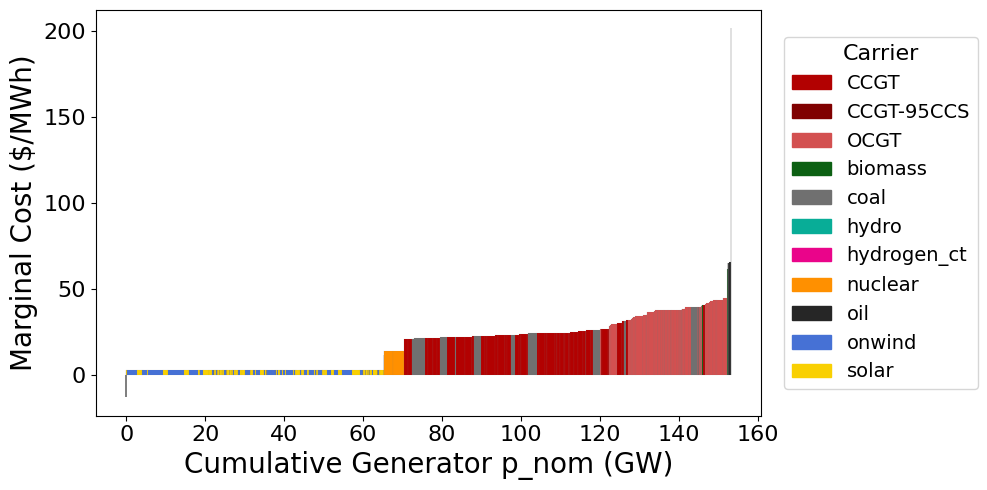

In [15]:
plot_generator_marginal_costs(network)

<Axes: xlabel='period,timestep'>

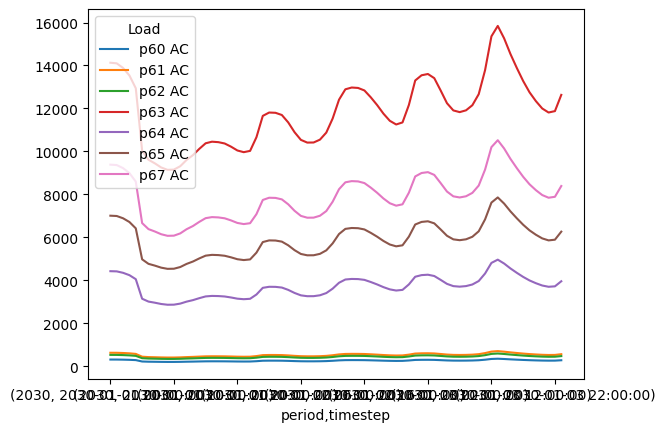

In [ ]:
network.loads_t.p_set.iloc[:72].plot()

<Axes: xlabel='period,timestep'>

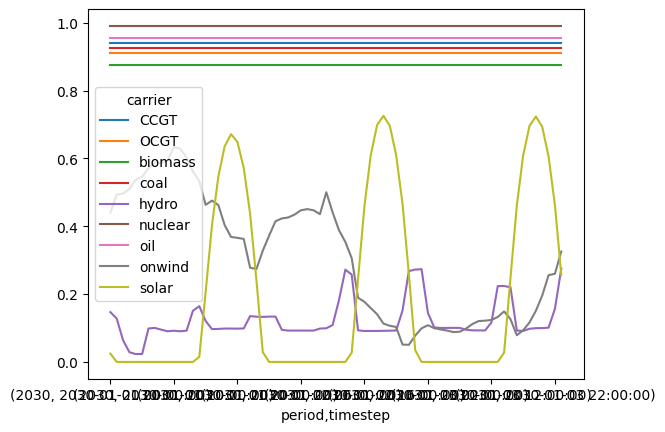

In [ ]:
network.generators_t.p_max_pu.loc[network.snapshots[0:7*24]].T.groupby(network.generators.carrier).mean().T.iloc[:72].plot()

In [ ]:
# The above sequence of commands is equivalent to:
network.optimize(
    snapshots=network.snapshots[0:1],
    solver_name='gurobi'
)

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io: Writing time: 0.15s


Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-01
Read LP format model from file /private/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/linopy-problem-4u7_g_0r.lp
Reading time = 0.01 seconds
obj: 2859 rows, 1419 columns, 4300 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 24.6.0 24G90)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2859 rows, 1419 columns and 4300 nonzeros
Model fingerprint: 0x997a362b
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [1e+01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+04]
Presolve removed 2852 rows and 1282 columns
Presolve time: 0.01s
Presolved: 7 rows, 137 columns, 159 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6521597e+04   4.460024e+03   0.000000e+00      0s
      14    3

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 1419 primals, 2859 duals
Objective: 3.80e+05
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

<Axes: xlabel='carrier'>

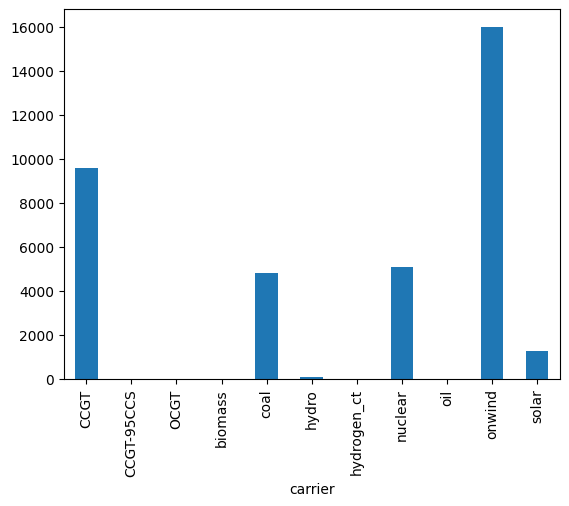

In [21]:
# lets look at the results
network.generators_t.p.loc[network.snapshots[0]].groupby(network.generators.carrier).sum().plot(kind="bar")

 Great! Most market simulations aren't limited to a single time-step. 
 Let's solve a week of the economic dispatch problem. With multiple time-steps, 
 new constraints are introduced into the formulation:
 - Generator Ramping Constraint
 - Storage Unit State-of-Charge Limit
 - Storage Unit Charge and Discharge Limits
 - Storage Unit Energy Evolution Constraint

 and (if you weren't paying attention) we actually had transmission lines in the last problem! so lets add line flow constraints

$$
\begin{aligned}
\min_{p,\;s^{in},\;s^{out},\;SOC} \quad 
& \sum_{t \in T} \sum_{g \in G} o_{g,t}\, p_{g,t} \\[0.5em]
\text{subject to:} \quad
& p_{g,t} \le \widetilde{p}^{\max}_{g,t}\,\overline{P}_{g} 
&& \forall g \in G,\; t \in T \\[0.5em]
& RD_g \le p_{g,t} - p_{g,t-1} \le RU_g 
&& \forall g \in G,\; t \in T \\[0.5em]
& 0 \le SOC_{s,t} \le h_s\,\overline{S}_{s} 
&& \forall s \in S,\; t \in T \\[0.5em]
& 0 \le s^{out}_{s,t} \le \overline{S}_{s} 
&& \forall s \in S,\; t \in T \\[0.5em]
& 0 \le s^{in}_{s,t} \le \overline{S}_{s} 
&& \forall s \in S,\; t \in T \\[0.5em]
& SOC_{s,t} = SOC_{s,t-1} + \eta^{in}\, s^{in}_{s,t} - \frac{1}{\eta^{out}}\, s^{out}_{s,t} 
&& \forall s \in S,\; t \in T \\[0.5em]
& \widetilde{f}_{b,t}^{\text{min}} \bar{f}_{b} 
  \leq f_{b,t} 
  \leq \widetilde{f}_{b,t}^{\text{max}} \bar{f}_{b} 
  && \forall b \in B,\; t \in T_a     \\[0.5em]
& \sum_{g \in G} p_{g,t,n}
  + \sum_{s \in S} s^{out}_{s,t,n}
  - \sum_{s \in S} s^{in}_{s,t,n}
  = D_{t,n}
&& \forall n \in N,\; t \in T
\end{aligned}
$$


In [35]:
network.optimize(
    snapshots=network.snapshots[0:7*24],
    solver_name='gurobi'
)

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 5/5 [00:00<00:00,  8.50it/s]
INFO:linopy.io: Writing time: 4.81s


Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-01
Read LP format model from file /private/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/linopy-problem-g7bjsjdj.lp
Reading time = 1.43 seconds
obj: 626270 rows, 238392 columns, 1017837 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 24.6.0 24G90)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 626270 rows, 238392 columns and 1017837 nonzeros
Model fingerprint: 0x8487fa25
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [1e+01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 2e+04]
Presolve removed 623584 rows and 210329 columns
Presolve time: 0.50s
Presolved: 2686 rows, 28397 columns, 36289 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statist

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 238392 primals, 626270 duals
Objective: 4.22e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, Link-fix-p-lower, Link-fix-p-upper, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

In [36]:
network.generators_t.p.loc[network.snapshots[0:7*24]].T.groupby(network.generators.carrier).sum()

period                     2030                                          \
timestep    2030-01-01 00:00:00 2030-01-01 01:00:00 2030-01-01 02:00:00   
carrier                                                                   
CCGT                7030.546300         6763.047095           7030.5463   
CCGT-95CCS             0.000000            0.000000              0.0000   
OCGT                   0.000000            0.000000              0.0000   
biomass                0.000000            0.000000              0.0000   
coal                4644.661660         4420.089747           3136.2101   
hydro                 90.600000           78.900000             39.3000   
hydrogen_ct            0.000000            0.000000              0.0000   
nuclear             5089.845200         5089.845200           5089.8452   
oil                    0.000000            0.000000              0.0000   
onwind             15992.613303        17793.370550          19917.8128   
solar               1261.878195            0.000000              0.0000   

period                                                                   \
timestep    2030-01-01 03:00:00 2030-01-01 04:00:00 2030-01-01 05:00:00   
carrier                                                                   
CCGT                4211.524552         1566.043800            0.000000   
CCGT-95CCS             0.000000            0.000000            0.000000   
OCGT                   0.000000            0.000000            0.000000   
biomass                0.000000            0.000000            0.000000   
coal                3136.210100         3006.828107            0.000000   
hydro                 17.600000           14.300000           14.400000   
hydrogen_ct            0.000000            0.000000            0.000000   
nuclear             5089.845200         4619.664949         3829.914949   
oil                    0.000000            0.000000            0.000000   
onwind             22955.026937        24758.397471        25270.383964   
solar                  0.000000            0.000000            0.000000   

period                                                                   \
timestep    2030-01-01 06:00:00 2030-01-01 07:00:00 2030-01-01 08:00:00   
carrier                                                                   
CCGT                   0.000000            0.000000            0.000000   
CCGT-95CCS             0.000000            0.000000            0.000000   
OCGT                   0.000000            0.000000            0.000000   
biomass                0.000000            0.000000            0.000000   
coal                   0.000000            0.000000            0.000000   
hydro                 60.829692           61.814918           58.682427   
hydrogen_ct            0.000000            0.000000            0.000000   
nuclear             3040.164949         2659.845200         2659.845200   
oil                    0.000000            0.000000            0.000000   
onwind             26428.450776        26492.946467        25626.412420   
solar                  0.000000            0.000000            0.000000   

period                           ...                                          \
timestep    2030-01-01 09:00:00  ... 2030-01-07 14:00:00 2030-01-07 15:00:00   
carrier                          ...                                           
CCGT                   0.000000  ...         6862.370961         6419.909533   
CCGT-95CCS             0.000000  ...            0.000000            0.000000   
OCGT                   0.000000  ...            0.000000            0.000000   
biomass                0.000000  ...            0.000000            0.000000   
coal                   0.000000  ...         4796.692300         4796.692300   
hydro                 55.783400  ...          168.101805          167.040014   
hydrogen_ct            0.000000  ...            0.000000            0.000000   
nuclear             2720.595200  ...         50

But this only includes generators! we have storage units in out model and potentially stores, links, etc in other models!

In [37]:
network.carriers.loc['AC_exp', 'color'] = "#000000"

/Users/kamrantehranchi/Local_Documents/energy310_notebooks/.venv/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1800: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



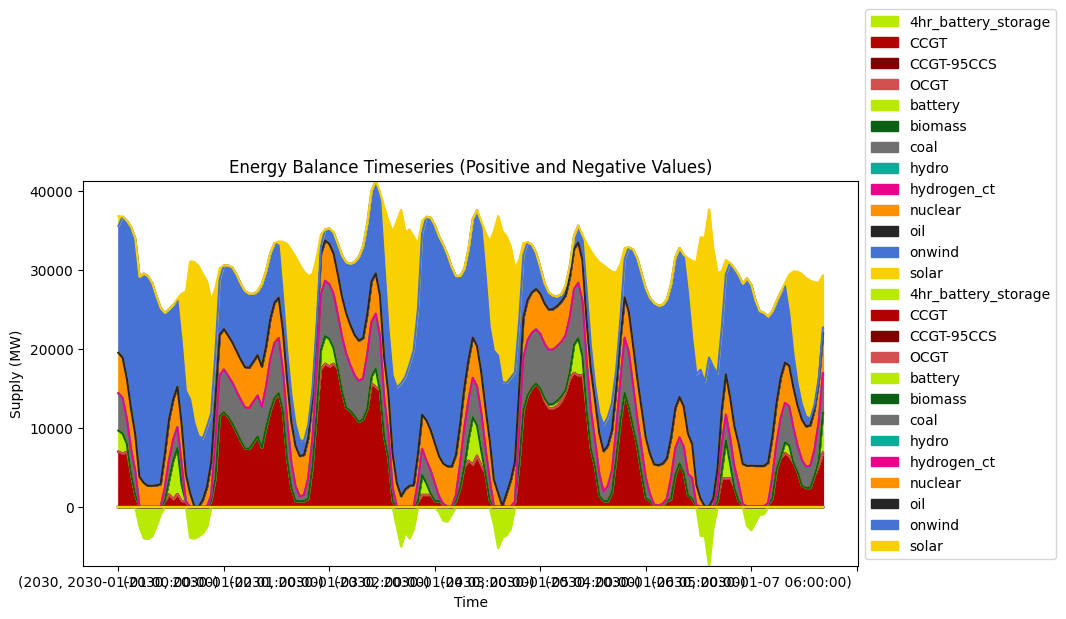

(<Figure size 1000x500 with 1 Axes>,
 <Axes: title={'center': 'Energy Balance Timeseries (Positive and Negative Values)'}, xlabel='Time', ylabel='Supply (MW)'>)

In [38]:
plot_energy_balance(network, 7*24)

In [39]:
network.statistics()

Optimal Capacity Installed Capacity  \
                                                    2030               2030   
Generator   Biomass                              137.000            137.000   
            Ccgt-95Ccs                               NaN                NaN   
            Coal                               14329.700          14329.700   
            Combined-Cycle Gas                 41404.100          41404.100   
            Hydrogen Combustion Turbine              NaN                NaN   
            Nuclear                             5138.600           5138.600   
            Oil                                  799.800            799.800   
            Onshore Wind                       34363.600          34363.600   
            Open-Cycle Gas                     17071.700          17071.700   
            Reservoir & Dam                      555.100            555.100   
            Solar                              30326.000          30326.000   
Link        Ac                                 99247.628          99247.628   
Load        Ac                                     0.000              0.000   
StorageUnit 4Hr_Battery_Storage                      NaN                NaN   
            Battery Storage                    10332.200          10332.200   

                                               Supply    Withdrawal  \
                                                 2030          2030   
Generator   Biomass                               NaN           NaN   
            Ccgt-95Ccs                            NaN           NaN   
            Coal                         5.425517e+05           NaN   
            Combined-Cycle Gas           9.279408e+05           NaN   
            Hydrogen Combustion Turbine           NaN           NaN   
            Nuclear                      7.611423e+05           NaN   
            Oil                                   NaN           NaN   
            Onshore Wind                 1.974726e+06           NaN   
            Open-Cycle Gas                        NaN           NaN   
            Reservoir & Dam              1.757800e+04           NaN   
            Solar                        9.198583e+05           NaN   
Link        Ac                                    NaN  2.944374e+06   
Load        Ac                                    NaN  5.062156e+06   
StorageUnit 4Hr_Battery_Storage                   NaN           NaN   
            Battery Storage              8.480677e+04  9.977267e+04   

                                        Energy Balance  Transmission  \
                                                  2030          2030   
Generator   Biomass                                NaN  0.000000e+00   
            Ccgt-95Ccs                             NaN  0.000000e+00   
            Coal                          5.425517e+05  0.000000e+00   
            Combined-Cycle Gas            9.279408e+05  0.000000e+00   
            Hydrogen Combustion Turbine            NaN  0.000000e+00   
            Nuclear                       7.611423e+05  0.000000e+00   
            Oil                                    NaN  0.000000e+00   
            Onshore Wind                  1.974726e+06  0.000000e+00   
            Open-Cycle Gas                         NaN  0.000000e+00   
            Reservoir & Dam               1.757800e+04  0.000000e+00   
            Solar                         9.198583e+05  0.000000e+00   
Link        Ac                           -2.944374e+06  2.944374e+06   
Load        Ac                           -5.062156e+06  0.000000e+00   
StorageUnit 4Hr_Battery_Storage                    NaN  0.000000e+00   
            Battery Storage              -1.496590e+04  0.000000e+00   

                                        Capacity Factor   Curtailment  \
                                                   2030          2030   
Generator   Biomass                                 NaN  1.077287e+06   
            Ccgt-95Ccs                      

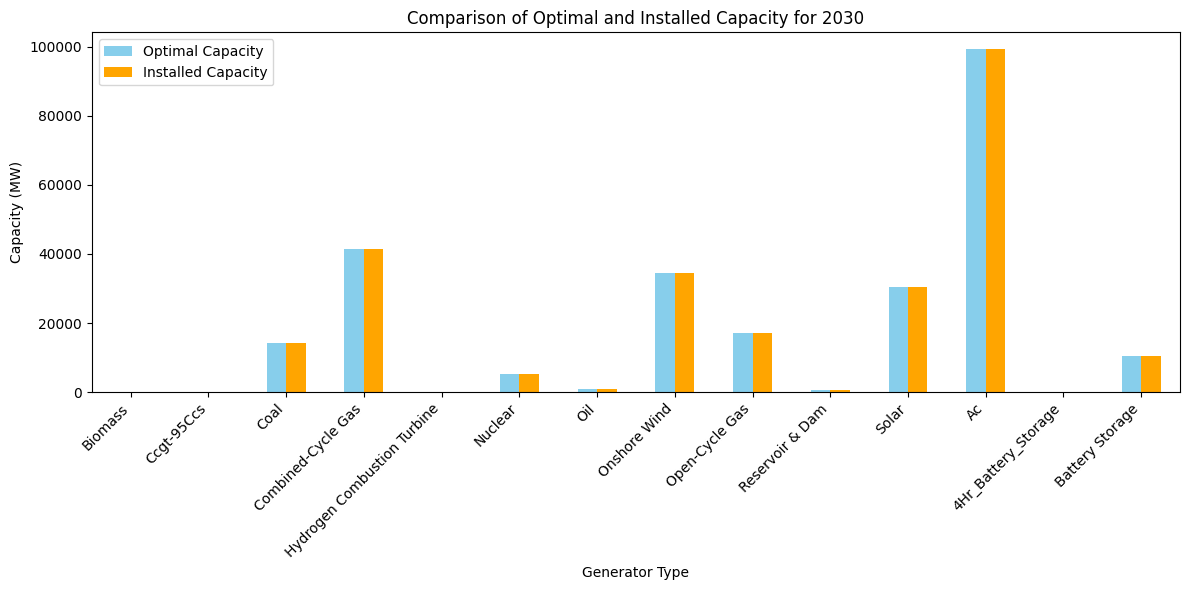

In [40]:
plot_capacity_comparison(network)

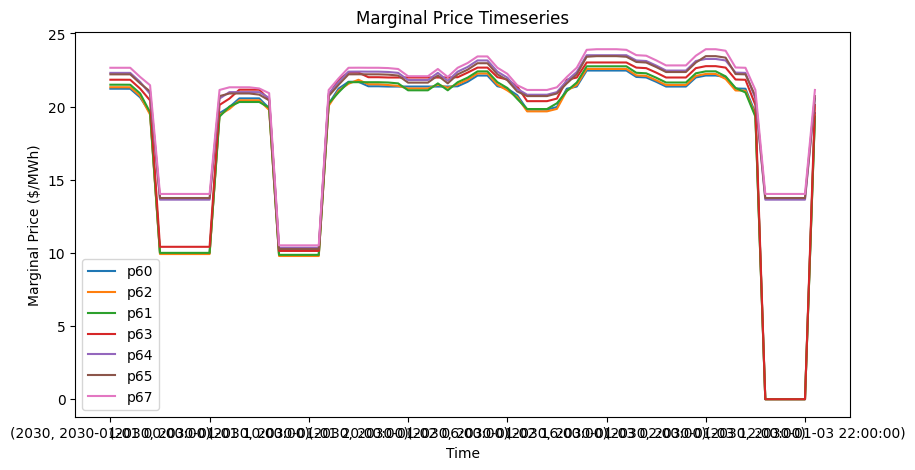

In [41]:
fig, ax = plt.subplots(figsize=(10, 5))
network.buses_t.marginal_price.iloc[:72].plot(ax=ax)
ax.set_title("Marginal Price Timeseries")
ax.set_ylabel("Marginal Price ($/MWh)")
ax.set_xlabel("Time")
plt.show()


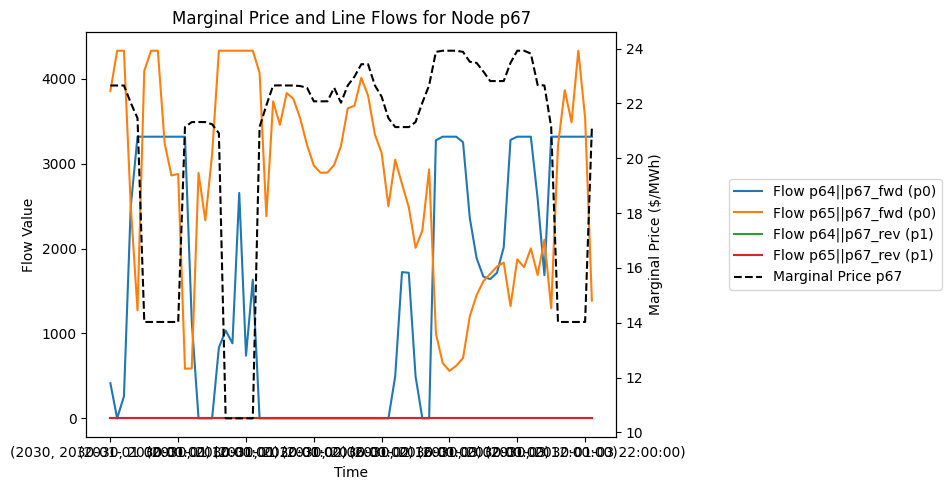

In [42]:
fig, ax1 = plt.subplots(figsize=(10, 5))

node = 'p67'
# Create a second y-axis for the marginal price
ax2 = ax1.twinx()

# Plot marginal price for node p64 as a dotted line on the second y-axis
network.buses_t.marginal_price[node].iloc[:72].plot(ax=ax2, linestyle='--', color='black', label='Marginal Price '+node)

# Find links connected to node p64
links_p64 = network.links[(network.links['bus0'] == node) | (network.links['bus1'] == node)]

# Plot line flows for links connected to node p64
for link in links_p64.index:
    if 'fwd' in link:
        network.links_t.p0[link].iloc[:72].plot(ax=ax1, label=f'Flow {link} (p0)')
    elif 'rev' in link:
        network.links_t.p1[link].iloc[:72].plot(ax=ax1, label=f'Flow {link} (p1)')
    # break

ax1.set_title("Marginal Price and Line Flows for Node "+node)
ax1.set_ylabel("Flow Value")
ax1.set_xlabel("Time")
ax2.set_ylabel("Marginal Price ($/MWh)")

# Combine legends from both y-axes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='center left', bbox_to_anchor=(1.2, 0.5))

plt.tight_layout()
plt.show()

### Network Clustering Example

Lets make this a single node ("Copper plate") network via the pypsa.clustering functionality

In [43]:
busmap = network.buses.interconnect
cols = ['Pd', 'country', 'reeds_zone']
[network.buses.drop(columns=col, inplace=True) for col in cols if col in network.buses.columns]
clustered_network = network.cluster.cluster_by_busmap(busmap)

       'p61||p63_fwd', 'p61||p64_fwd', 'p61||p65_fwd', 'p63||p64_fwd',
       'p64||p65_fwd', 'p64||p67_fwd', 'p65||p67_fwd', 'p60||p61_rev',
       'p60||p62_rev', 'p60||p63_rev', 'p61||p62_rev', 'p61||p63_rev',
       'p61||p64_rev', 'p61||p65_rev', 'p63||p64_rev', 'p64||p65_rev',
       'p64||p67_rev', 'p65||p67_rev'],
      dtype='object', name='Link') for attribute p0 of Link are not in main components dataframe links
       'p61||p63_fwd', 'p61||p64_fwd', 'p61||p65_fwd', 'p63||p64_fwd',
       'p64||p65_fwd', 'p64||p67_fwd', 'p65||p67_fwd', 'p60||p61_rev',
       'p60||p62_rev', 'p60||p63_rev', 'p61||p62_rev', 'p61||p63_rev',
       'p61||p64_rev', 'p61||p65_rev', 'p63||p64_rev', 'p64||p65_rev',
       'p64||p67_rev', 'p65||p67_rev'],
      dtype='object', name='Link') for attribute p1 of Link are not in main components dataframe links


In [44]:
clustered_network

PyPSA Network 'Unnamed Network'
-------------------------------
Components:
 - Bus: 1
 - Carrier: 17
 - Generator: 1355
 - GlobalConstraint: 1
 - Load: 7
 - StorageUnit: 14
 - SubNetwork: 1
Snapshots: 8760

In [45]:
clustered_network.optimize(snapshots=clustered_network.snapshots[0:72], solver_name="gurobi")

INFO:linopy.model: Solve problem using Gurobi solver
INFO:linopy.io:Writing objective.
Writing continuous variables.: 100%|██████████| 4/4 [00:00<00:00, 15.88it/s]
INFO:linopy.io: Writing time: 1.95s


Set parameter Username
Academic license - for non-commercial use only - expires 2026-01-01
Read LP format model from file /private/var/folders/00/vqry7y9s78q3rvf_m_jmk_bc0000gn/T/linopy-problem-8y8k_i5c.lp
Reading time = 0.43 seconds
obj: 264302 rows, 100584 columns, 428877 nonzeros
Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (mac64[x86] - Darwin 24.6.0 24G90)

CPU model: Intel(R) Core(TM) i7-1068NG7 CPU @ 2.30GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 264302 rows, 100584 columns and 428877 nonzeros
Model fingerprint: 0x20bac07a
Coefficient statistics:
  Matrix range     [9e-01, 1e+00]
  Objective range  [1e+01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 4e+04]
Presolve removed 263584 rows and 97547 columns
Presolve time: 0.26s
Presolved: 718 rows, 3179 columns, 4975 nonzeros

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Ordering time: 0.00s

Barrier statistics:
 

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 100584 primals, 264302 duals
Objective: 1.92e+07
Solver model: available
Solver message: 2

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-fix-p-ramp_limit_up, Generator-fix-p-ramp_limit_down, StorageUnit-fix-p_dispatch-lower, StorageUnit-fix-p_dispatch-upper, StorageUnit-fix-p_store-lower, StorageUnit-fix-p_store-upper, StorageUnit-fix-state_of_charge-lower, StorageUnit-fix-state_of_charge-upper, StorageUnit-energy_balance were not assigned to the network.


('ok', 'optimal')

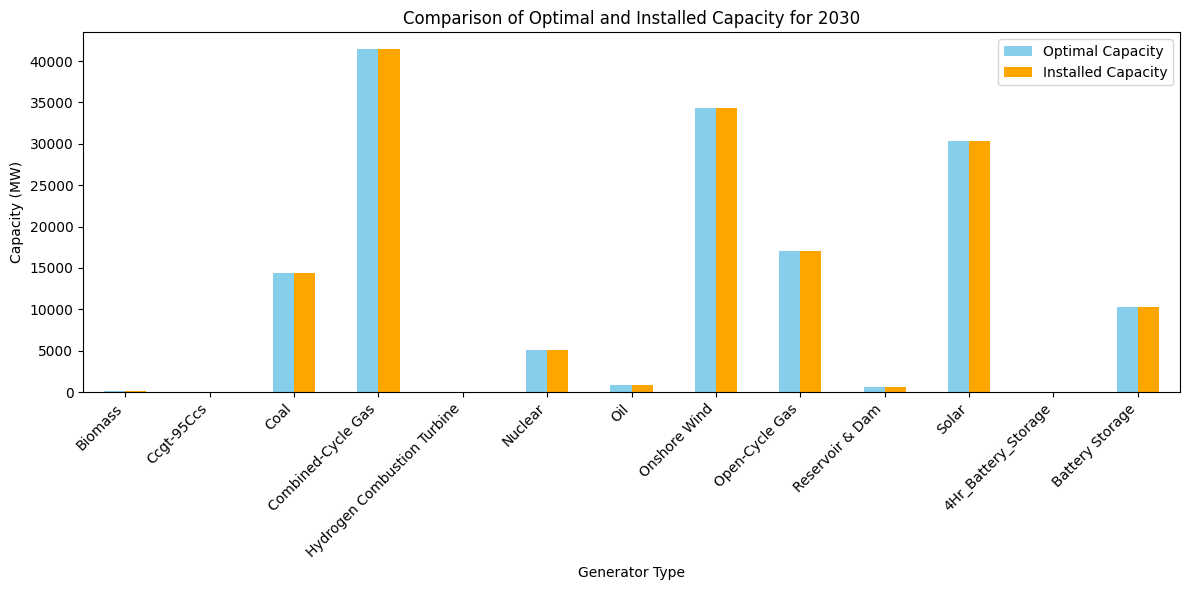

In [46]:
plot_capacity_comparison(clustered_network)

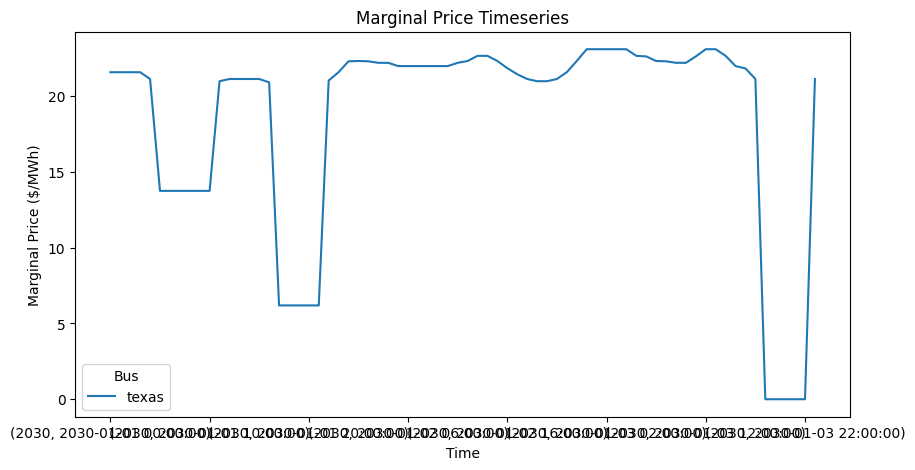

In [47]:
fig, ax = plt.subplots(figsize=(10, 5))
clustered_network.buses_t.marginal_price.iloc[:72].plot(ax=ax)
ax.set_title("Marginal Price Timeseries")
ax.set_ylabel("Marginal Price ($/MWh)")
ax.set_xlabel("Time")
plt.show()


/Users/kamrantehranchi/Local_Documents/energy310_notebooks/.venv/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1800: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



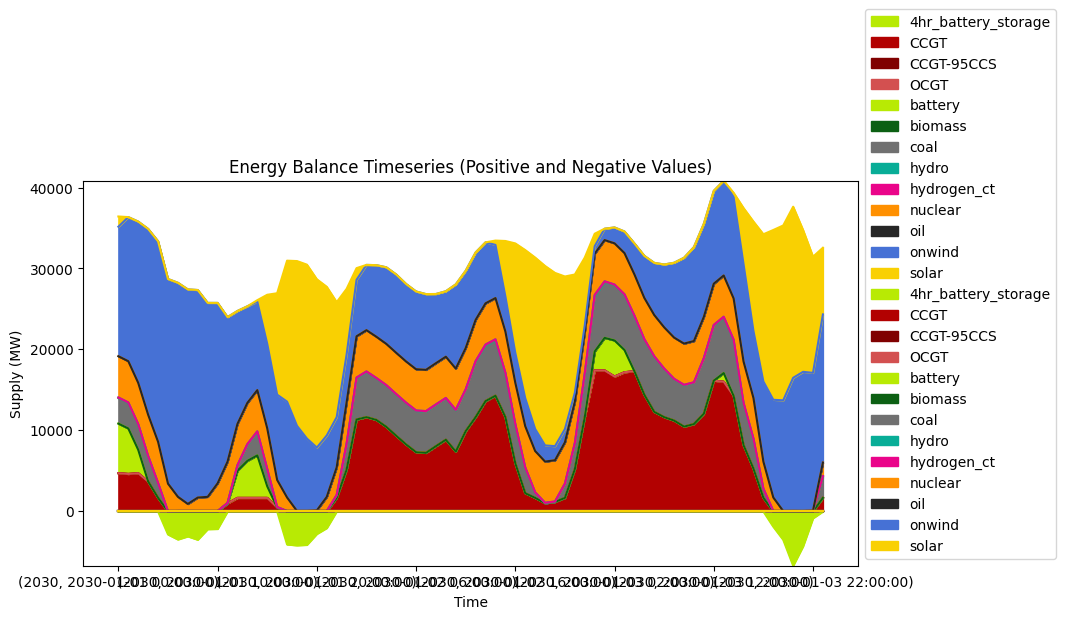

In [48]:
fig_pr, ax_pr = plot_energy_balance(clustered_network, 24 * 3)